In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import thejoker
import scipy.stats
import GP_class
import george
import numpy.random as rnd

import sys
import time as tm

In [68]:
def read_data(filename, whitespace=False, datadir="./"):
    """
    Read in light curve data from asteroid.
    """

    data  = pd.read_csv(datadir+filename, header=None, delim_whitespace=whitespace)

    tsample = data[0]
    fsample = data[1]
    flux_err = data[2]

    return tsample, fsample, flux_err

time, flux, flux_err = read_data("../data/simulation_results_new/3200/3200_lc_49627_to_49787.txt_sampled_talc_14days.txt")

In [69]:
# 1 : set up the prior distriubtion

# try the  np norm distriubtion : np.random.norm
# as computing about timing scripts
# time it scipy vs numpy

prior_mean = scipy.stats.norm(1, 0.5)
prior_log_amp = scipy.stats.norm(np.log(0.15), np.log(2))
prior_log_gamma = scipy.stats.norm(np.log(10), np.log(2))
prior_log_period = scipy.stats.norm(np.log(4./24.), (12./24.))

In [70]:
%time
nsamples = 10**4

J_mean = prior_mean.rvs(nsamples)
J_log_amp = prior_log_amp.rvs(nsamples)
J_log_gamma = prior_log_gamma.rvs(nsamples)
J_log_period= prior_log_period.rvs(nsamples)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [71]:
#%timeit rnd.randn(1000000)

#J  = J*0.5 + np.log(4/24.)
# multiply by st dev and add mean

In [72]:
mean_flux = np.mean(flux)
log_amp = np.log(flux.max()-flux.min())
gamma = 1
log_period = 0

In [73]:
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=mean_flux)
gp.compute(time, flux_err)

In [120]:
def calculate_likelihood(i):
    params = [J_mean[i], J_log_amp[i], np.exp(J_log_gamma[i]), J_log_period[i]]
    gp.set_parameter_vector(params)

    try:
        #gp.compute(time, flux_err)
        lnlike = gp.log_likelihood(flux)
    except np.linalg.LinAlgError:
        lnlike = -1e25

    #L_results[i] = lnlike
    
    return [lnlike, i]

In [ ]:
%%prun
# 2: for each j, calculate the log likelihood

L_results = np.ones(nsamples)

start_time = tm.time()

for i in np.arange(nsamples):

    p = ((i+1)/nsamples)*100
    if p.is_integer():
        sys.stdout.write('\r'+str(int(p))+"%")

    params = [J_mean[i], J_log_amp[i], np.exp(J_log_gamma[i]), J_log_period[i]]

    gp.set_parameter_vector(params)

    try:
        #gp.compute(time, flux_err)
        lnlike = gp.log_likelihood(flux)
    except np.linalg.LinAlgError:
        lnlike = -1e25

    L_results[i] = lnlike
        
end_time = tm.time()

print("\ntotal time taken for this loop: %.2f seconds" %(end_time - start_time))


In [145]:
# Parallelizing using Pool.map()
import multiprocessing as mp

# Redefine, with only 1 mandatory argument.
#def howmany_within_range_rowonly(row, minimum=4, maximum=8):
#    count = 0
#    for n in row:
#        if minimum <= n <= maximum:
#            count = count + 1
#    return count

#pool = mp.Pool(mp.cpu_count())

#results = pool.map(howmany_within_range_rowonly, [row for row in data])

#pool.close()



#print(results[:10])
########################################33
#start_time = tm.time()
#L_results = np.ones(nsamples)
start_time = tm.time()


pool = mp.Pool(mp.cpu_count())

L_results = []
L_results = pool.map(calculate_likelihood, [i for i in np.arange(nsamples)])

pool.close()

end_time = tm.time()
print("\ntotal time taken for this loop: %.2f seconds" %(end_time - start_time))


total time taken for this loop: 1.14 seconds


In [146]:
(L_results[0])

[-2813.591648095077, 0]

In [78]:
L_results = np.ones(nsamples)

start_time = tm.time()

with mp.Pool(processes=mp.cpu_count()) as p:
    max_ = nsamples
    with tqdm(total=max_) as pbar:
        for i, _ in tqdm_notebook(enumerate(p.imap_unordered(calculate_likelihood, np.arange(max_)))):
            pbar.update()
        pbar.close(); del pbar
            
end_time = tm.time()
print("\ntotal time taken for this loop: %.2f seconds" %(end_time - start_time))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 7313.60it/s]




total time taken for this loop: 1.53 seconds


In [109]:
(L_results)

[(0, -2813.591648095077),
 (1, -3302.0990116568983),
 (2, -3360.0153332730715),
 (3, -2621.464425189468),
 (4, -3086.850069511439),
 (5, -3271.8809190501706),
 (6, -2988.4734975044726),
 (7, -2356.4159968876206),
 (8, -2892.8455228652347),
 (9, -3006.289061658592),
 (10, -2789.917154216632),
 (11, -2890.6515035951475),
 (12, -3677.6958857599375),
 (13, -2540.414440711723),
 (14, -3017.8568647073716),
 (15, -2470.6083238777687),
 (16, -2019.2087799072137),
 (17, -3437.640722983498),
 (18, -3571.872847350368),
 (19, -3416.3493864385987),
 (20, -2887.1077311144822),
 (21, -3012.350803543405),
 (22, -2892.7191129085395),
 (23, -2305.522434295531),
 (24, -1947.3278323788834),
 (25, -2194.164814167385),
 (26, -2381.1415628597165),
 (27, -3482.1409628959445),
 (28, -3702.413866902434),
 (29, -3223.562680022802),
 (30, -3682.820830293011),
 (31, -2224.372268928867),
 (32, -2557.489917706629),
 (33, -2802.9962353652127),
 (34, -3832.517630923495),
 (35, -1874.0619978107093),
 (36, -2893.3911762

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0,0].scatter(np.exp(J_log_period)*24., L_results)

L_max_period = np.exp(J_log_period[np.where(L_results==L_results.max())])*24.
ax[0,0].vlines(L_max_period, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
ax[0,0].legend()
ax[0,0].set_title("Period (hours)")


ax[0,1].scatter(J_mean, L_results)

L_max_mean = J_mean[np.where(L_results==L_results.max())]
ax[0,1].vlines(L_max_mean, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_mean, linestyles='dashed', alpha=0.7)
ax[0,1].legend()
ax[0,1].set_title("Mean")


ax[1,0].scatter(J_log_amp, L_results)

L_max_amp = np.exp(J_log_amp[np.where(L_results==L_results.max())])
ax[1,0].vlines(L_max_amp, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_amp, linestyles='dashed', alpha=0.7)
ax[1,0].legend()
ax[1,0].set_title("Amplitude")

ax[1,1].scatter(np.exp(J_log_gamma), L_results)

L_max_gamma = np.exp(J_log_gamma[np.where(L_results==L_results.max())])
ax[1,1].vlines(L_max_gamma, L_results.min(), L_results.max(), label="Lmax: %f" %L_max_gamma, linestyles='dashed', alpha=0.7)
ax[1,1].legend()
ax[1,1].set_title("Gamma")

In [141]:
# 3 : Pick a random number r out of a uniform distribution between 0 and Lmax
uu = rnd.uniform(size=len(L_results))

good_samples_bool = uu < np.exp(L_results-max(L_results))
good_samples_idx, = np.where(good_samples_bool)

len(good_samples_idx)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [142]:
(L_results-max(L_results))

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [137]:
L_results.T

AttributeError: 'list' object has no attribute 'T'

In [48]:
len(J_log_period)

100000

ValueError: x and y must be the same size

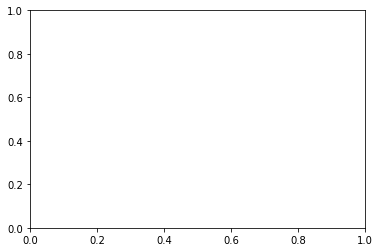

In [59]:
plt.scatter(np.exp(J_log_period)*24., np.exp(L_results-max(L_results)))

# plot l_max
L_max_period = np.exp(J_log_period[np.where(L_results==max(L_results))])*24.
plt.vlines(L_max_period, 0, 1, label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
plt.legend()

In [ ]:
plt.scatter(J_mean, np.exp(L_results-L_results.max()))

# plot l_max
L_max_mean = J_mean[np.where(L_results==L_results.max())]
plt.vlines(L_max_mean, 0, 1, label="Lmax: %f" %L_max_period, linestyles='dashed', alpha=0.7)
plt.legend()

In [ ]:
len(good_samples_idx)

In [ ]:
import plotting

In [ ]:
plotting.plot_folded_lightcurve(time, flux, period = np.exp(J_log_period[np.where(L_results==L_results.max())]))

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

In [ ]:
import numpy as np
from time import time

# Prepare data
np.random.RandomState(100)
arr = np.random.randint(0, 10, size=[200000, 5])
data = arr.tolist()
data[:5]

In [ ]:
# Solution Without Paralleization

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

results = []
for row in data:
    results.append(howmany_within_range(row, minimum=4, maximum=8))

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [ ]:
# Parallelizing using Pool.apply()

import multiprocessing as mp

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())

# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]

# Step 3: Don't forget to close
pool.close()    

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]

In [ ]:
# Parallelizing using Pool.map()
import multiprocessing as mp

# Redefine, with only 1 mandatory argument.
def howmany_within_range_rowonly(row, minimum=4, maximum=8):
    count = 0
    for n in row:
        if minimum <= n <= maximum:
            count = count + 1
    return count

pool = mp.Pool(mp.cpu_count())

results = pool.map(howmany_within_range_rowonly, [row for row in data])

pool.close()

print(results[:10])
#> [3, 1, 4, 4, 4, 2, 1, 1, 3, 3]